# IBM Data Science Professional Certificate Capstone Project 

## Centers of crime and nearby popular venues in Tacoma, Washington

![Tacoma](http://images.trvl-media.com/media/content/shared/images/travelguides/Tacoma-6046853-smallTabletRetina.jpg)

### Introduction
This study explores relationships between locations with high rates of reported crime and popular venues nearby in Tacoma, Washington.  
Tacoma is an important seaport city on the Puget Sound. [In 2012 Tacoma ranked as the 11th busiest container port in North America.](https://www.seattletimes.com/business/economy/rivalry-between-seattle-and-tacoma-ports-historic-detrimental/) The ports of Tacoma and Seattle, only about 30 miles apart, merged in 2015 to create the Northwest Seaport Alliance, [which is now the 5th largest port in North America.](https://www.porttechnology.org/news/top-5-ports-in-the-usa/)
Tacoma, with an [estimated population of 217,827](https://www.census.gov/quickfacts/fact/table/tacomacitywashington/PST045219), has earned the nickname ["Grit City"](https://gritcitymag.com/2019/09/the-real-story-behind-tacomas-nickname-grit-city/) due to its heavy industry and tough working class character. Tacoma is also famous in the region for its ["aroma"](https://en.wikipedia.org/wiki/Aroma_of_Tacoma).

This study could be of interest to public policy makers, law enforcement, and the concerned citizens of Tacoma. If we find crimes clustered around certain types of venues, then we can seek to understand why. We can even take action to prevent it, or at least avoid being a victim. My initial hypothosis is that we will find increased incidents of certain types of crimes, such as robbery and assult near certain types of venues such as night clubs and strip clubs. Let's find out what the data tells us.

### Data
The Tacoma crime data used in this report is available from cityoftacoma.org at https://data.cityoftacoma.org/Public-Safety/Tacoma-Crime/wtqi-kpsn/data.
This dataset contains 118k rows and 5 columns (Incident Number, Crime, Occurred On, Approximate Time, and intersection). The intersection column contain the latitude and longitude, which will need to be parsed into two new numeric columns. The incidents span the 6 year period from the beginning of 2014 to the end of 2019.

Data about venues is from Foursquare.com. I will use the "Venue Recomendations" endpoint, which "returns a list of recommended venues near the current location". 

I will group the crime data by latitude, longitude, and crime type, and get the count of incidents of crime type at location. Then I will plot the top 100 groups by incident count on the map of Tacoma. Each of these top locations will be passed as the "current location" required by the "Venue Recomendations" endpoint. The recomended venues will be plotted on the map of tacoma along with the crime locations. 

To find correlations between crimes and venue categories, I will use one-hot encoding to turn the categorical data into numeric data. Then I will use Pearson correlation to determine if there are any significant relationships between high concentrations of particular types of crime and categories of popular venues in the same location, and also between different crime types at the same location.

### Methodology

In this section, I use Pandas to explore and profile the data. Initially, there are 118,182 rows and 5 columns of crime data. Using the min and max functions on the date column reveals the date range of the data is from January 2014 through December 2019. The latitude and longitude data is embedded in the text description of the city block where the incident occurred. I add numeric columns to the dataframe for latitude and longitude, and parse the city block description to populate the new columns. Some rows do not contain latitude and longitude. Those rows are useless, so I cleanse the data by dropping those rows. After data cleansing, there are 110,842 rows and 7 columns.
I group the crime data by location and crime and plot the top locations on the map of Tacoma using Folium. I use the Foursquare API to learn about popular venues within a small radius of the crime locations and add these to the Folium map as well.  
The goal is to find correlations between crimes and venue categories. These are categorical data, so I use Pandas get_dummies function to create a one-hot encoded, numeric dataframe containing the crimes and venue categories. Then I use the corr function to find Pearson correlation coefficients between crimes and categories, and crimes and other crimes.  
In the Results section, I use Seaborn to visualize the discoveries obtained from the data.

In [2]:
import pandas as pd
import numpy as np
import requests
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [3]:
CLIENT_ID = 'I45Y3F3MAJLMIG3AYECKN5UYGEONAAY13SERXS2SO0CLAFWU'
CLIENT_SECRET = 'ZXVBJQ4EK0KMUVRL5CB3QJDNJCIZF2ACS00RYBVB2QKPKS3K'
VERSION = '20201101'

A cursory look at the dataset shows that we have 118k rows and 5 columns. The incidents span the 6 year period from the beginning of 2014 to the end of 2019.

In [222]:
#tacoma_crime = pd.read_csv("Tacoma_Crime.csv")
tacoma_crime = pd.read_csv("https://data.cityoftacoma.org/api/views/wtqi-kpsn/rows.csv?accessType=DOWNLOAD")
# print the number of rows and columns
print(tacoma_crime.shape)
# print the date range of the data
print(tacoma_crime[['Occurred On']].min())
print(tacoma_crime[['Occurred On']].max())
print(tacoma_crime.head())

(118574, 5)
Occurred On    01/01/2014
dtype: object
Occurred On    12/31/2019
dtype: object
  Incident Number                                    Crime Occurred On  \
0      1922609018                 Theft From Motor Vehicle  08/13/2019   
1      1906701038                              Shoplifting  03/08/2019   
2      1824201072                           Simple Assault  08/30/2018   
3      1806400608  False Pretenses/Swindle/Confidence Game  01/13/2018   
4      1806301267                 Stolen Property Offenses  03/04/2018   

  Approximate Time                                       intersection  
0            23:00  2000 E 63RD ST\nTACOMA, WA\n(47.199891, -122.4...  
1            12:00  7000 TACOMA MALL BLVD\nTACOMA, WA\n(47.192903,...  
2            13:00  600 PUYALLUP AV\nTACOMA, WA\n(47.240934, -122....  
3            13:00  3700 S PINE ST\nTACOMA, WA\n(47.224152, -122.4...  
4            17:00                            S S 19TH ST\nTACOMA, WA  


The latidude and longitude are embedded in the intersection column. To make grouping and mapping easier we will add two new columns to the dataframe for latitude and longitude.

In [5]:
# split the coordinates out of intersection into 2 new columns
tacoma_crime['Latitude'] = np.nan
tacoma_crime['Longitude'] = np.nan

# can't see how to split the intersection column inline because the start and stop positions with the string are not constant.
# need to find the position of "(" and then the following "," for each row.
# loop through the dataset and populate the latitude and longitude
for index, row in tacoma_crime.iterrows():
    try:
        # latitude and longitude are enclosed in parentheses and separated by a comma
        start_index = str(row['intersection']).index("(") + 1
        end_index = str(row['intersection']).index(",", start_index + 1)
        tacoma_crime.at[index, 'Latitude'] = float(row['intersection'][start_index:end_index])
        
        start_index = end_index + 1
        end_index = str(row['intersection']).index(")")
        tacoma_crime.at[index, 'Longitude'] = float(row['intersection'][start_index:end_index].lstrip())
    except ValueError as e:
        # latitude and longitude are missing from this row. Nothing to do here, the value will already be NaN.
        pass

tacoma_crime.head(10)

,Incident Number,Crime,Occurred On,Approximate Time,intersection,Latitude,Longitude
0,1922609018,Theft From Motor Vehicle,08/13/2019,23:00,"2000 E 63RD ST\nTACOMA, WA\n(47.199891, -122.4...",47.199891,-122.402371
1,1906701038,Shoplifting,03/08/2019,12:00,"7000 TACOMA MALL BLVD\nTACOMA, WA\n(47.192903,...",47.192903,-122.463110
2,1824201072,Simple Assault,08/30/2018,13:00,"600 PUYALLUP AV\nTACOMA, WA\n(47.240934, -122....",47.240934,-122.426431
3,1806400608,False Pretenses/Swindle/Confidence Game,01/13/2018,13:00,"3700 S PINE ST\nTACOMA, WA\n(47.224152, -122.4...",47.224152,-122.473583
4,1806301267,Stolen Property Offenses,03/04/2018,17:00,"S S 19TH ST\nTACOMA, WA",NaN,NaN
5,1806002120,Theft From Motor Vehicle,03/01/2018,18:00,"2100 PACIFIC AV\nTACOMA, WA\n(47.242317, -122....",47.242317,-122.436192
6,1824200101,Drug/narcotic Violations,08/30/2018,4:00,"9000 S M ST\nTACOMA, WA\n(47.175364, -122.450747)",47.175364,-122.450747
7,1932709022,Theft From Motor Vehicle,11/22/2019,23:00,"2600 WESTRIDGE AV W\nTACOMA, WA\n(47.235896, -...",47.235896,-122.555092
8,1806400506,Theft From Motor Vehicle,03/05/2018,8:00,"500 S 7TH ST\nTACOMA, WA\n(47.257194, -122.443...",47.257194,-122.443916
9,1806400477,Destruction/Damage/Vandalism of Property,03/05/2018,8:00,"00 BROADWAY\nTACOMA, WA",NaN,NaN


Some rows are missing latitude and longitude, making them useless for this invenstigation. We will drop those rows.

In [6]:
print(tacoma_crime.isnull().sum())
# remove rows without latitude and longitude values from the dataframe
tacoma_crime.drop(tacoma_crime[np.isnan(tacoma_crime['Latitude'])].index, inplace=True)
print(tacoma_crime.isnull().sum())
print(tacoma_crime.shape)

Incident Number        0
Crime                  0
Occurred On            0
Approximate Time       0
intersection        1981
Latitude            7340
Longitude           7340
dtype: int64
Incident Number     0
Crime               0
Occurred On         0
Approximate Time    0
intersection        0
Latitude            0
Longitude           0
dtype: int64
(110842, 7)


Now the data is ready to work with. We have 110k rows of data after cleansing.

Let's look at the number of incidents for each type of crime.

In [293]:
tacoma_crime.Crime.value_counts()

Theft From Motor Vehicle                      20888
All Other Larceny                             18004
Burglary/Breaking & Entering                  14077
Motor Vehicle Theft                           11493
Destruction/Damage/Vandalism of Property      11179
Shoplifting                                    6678
Simple Assault                                 5800
Aggravated Assault                             3386
Credit Card/Automatic Teller Fraud             2944
Robbery                                        2718
Impersonation                                  2570
Theft of Motor Vehicle Parts/Accessories       2504
False Pretenses/Swindle/Confidence Game        2038
Counterfeiting/Forgery                         1411
Identity Theft                                  706
Drug/narcotic Violations                        665
Weapon Law Violations                           504
Violation of No Contact/Protection Order        501
Arson                                           479
Stolen Prope

Latitude and longitude values are not the exact location of the crime, but the coordinates for the 100 address of the block. That means we can group crimes by location as well as the type of crime. To start with, we will just look at the top incident count by crime and location overall.

In [7]:
groups = tacoma_crime.groupby(['Latitude','Longitude','Crime'])['Incident Number'].count().sort_values(ascending=False).reset_index(name='Count')
# let's just look at the top 100 crime at location groupings
tacoma_crime_groups = pd.DataFrame(groups, columns=['Latitude','Longitude','Crime','Count']).head(100)
print(tacoma_crime_groups)

     Latitude   Longitude                         Crime  Count
0   47.217857 -122.467608                   Shoplifting    550
1   47.217857 -122.467608             All Other Larceny    526
2   47.242213 -122.482564                   Shoplifting    392
3   47.217857 -122.467608      Theft From Motor Vehicle    341
4   47.242290 -122.482583                   Shoplifting    263
..        ...         ...                           ...    ...
95  47.242290 -122.482583      Theft From Motor Vehicle     46
96  47.242213 -122.482564  Burglary/Breaking & Entering     46
97  47.231273 -122.495200           Motor Vehicle Theft     46
98  47.238167 -122.479216             All Other Larceny     46
99  47.257194 -122.443916                Simple Assault     45

[100 rows x 4 columns]


In [296]:
tacoma_crime_groups.Crime.value_counts()

Theft From Motor Vehicle                    35
Shoplifting                                 28
All Other Larceny                           19
Simple Assault                               6
Burglary/Breaking & Entering                 5
Robbery                                      2
Motor Vehicle Theft                          2
Aggravated Assault                           1
Pornography/Obscene Material                 1
Destruction/Damage/Vandalism of Property     1
Name: Crime, dtype: int64

The largest groupings crime at location, by far, are "Theft From Motor Vehicle", "Shoplifting", and "All Other Larceny". We also see groupings of other crimes, including violent crime.

Now we will see how these points are distributed on the map.

In [8]:
import folium

In [286]:
tacoma_map = folium.Map(location=[47.25288,-122.44429], zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, cnt, crm in zip(tacoma_crime_groups.Latitude, tacoma_crime_groups.Longitude, tacoma_crime_groups.Count, tacoma_crime_groups.Crime):
    incidents.add_child(
        folium.Circle(
            [lat, lng],
            tooltip=folium.Tooltip("{v1}: {v2} Incidents".format(v1=crm, v2=cnt)),
            radius=100 # average city block is 100 meters
        )
    )
    
# add incidents to map
tacoma_map.add_child(incidents)

tacoma_map

We see the crimes are mostly clustered around downtown, along the freeways, and at the Tacoma mall. These are primarily the business districts and not residential areas.

Now we will explore the popular businesses nearest to these crime clusters using the Foursquare API.

In [9]:
distinct_lat_long = tacoma_crime_groups.groupby(['Latitude','Longitude']).agg({'Crime': list}).reset_index()
distinct_lat_long

,Latitude,Longitude,Crime
0,47.178986,-122.463200,[Theft From Motor Vehicle]
1,47.180364,-122.434065,[Shoplifting]
2,47.182844,-122.463236,[Theft From Motor Vehicle]
3,47.184659,-122.463201,[Shoplifting]
4,47.185599,-122.463169,[Theft From Motor Vehicle]
...,...,...,...
67,47.259172,-122.451895,"[Simple Assault, Theft From Motor Vehicle]"
68,47.259530,-122.453462,[Theft From Motor Vehicle]
69,47.266619,-122.515974,[Shoplifting]
70,47.301585,-122.515693,[Theft From Motor Vehicle]


In [73]:
# Some crime locations have fewer than 5 venues within a 1 block radius, by expanding the radius to 2 blocks we get somewhat different results.
# Let's view the result using both a 1 block and a 2 block radius
def get_top_venues(radius):
    top_venues_map = pd.DataFrame(columns=['crime.Latitude','crime.Longitude','venue.Latitude','venue.Longitude','venue.distance','venue.name','venue.category','crime list'])
    for index, row in distinct_lat_long.iterrows():

        RADIUS = radius
        LATITUDE = row['Latitude']
        LONGITUDE = row['Longitude']
        CRIME_LIST = row['Crime']

        # explore - Returns a list of recommended venues near the current location.
        # GET https://api.foursquare.com/v2/venues/explore
        # get the top 5 recommended venues near the crime location, sorted by distance
        explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&sortByDistance={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, RADIUS, 5, 1)

        results = requests.get(explore_url).json()
        items = results['response']['groups'][0]['items']
        dataframe = json_normalize(items)
        if len(dataframe.index) > 0:
            top_venues = dataframe.loc[:,['venue.name','venue.id','venue.location.distance','venue.location.lat','venue.location.lng','venue.location.address','venue.categories']]
            for i, r in top_venues.iterrows():
                top_venues_map = top_venues_map.append({'crime.Latitude':LATITUDE,'crime.Longitude':LONGITUDE,'venue.Latitude':r['venue.location.lat'],'venue.Longitude':r['venue.location.lng'],'venue.distance':r['venue.location.distance'],'venue.name':r['venue.name'],'venue.category':r['venue.categories'][0]['name'],'crime list':CRIME_LIST},ignore_index=True)


    return top_venues_map

top_venues_map_100 = get_top_venues(100)
top_venues_map_200 = get_top_venues(200)
top_venues_map_100.head()

/home/aaron/.local/lib/python3.5/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,crime.Latitude,crime.Longitude,venue.Latitude,venue.Longitude,venue.distance,venue.name,venue.category,crime list
0,47.178986,-122.4632,47.178658,-122.462883,43,taqureia mas grandes,Mexican Restaurant,[Theft From Motor Vehicle]
1,47.178986,-122.4632,47.179584,-122.462958,68,Shell,Gas Station,[Theft From Motor Vehicle]
2,47.178986,-122.4632,47.178758,-122.464138,75,Denny's,Breakfast Spot,[Theft From Motor Vehicle]
3,47.178986,-122.4632,47.178552,-122.462244,86,i5 Pho - The Noodle Soup House,Vietnamese Restaurant,[Theft From Motor Vehicle]
4,47.178986,-122.4632,47.178460,-122.464103,89,Comfort Inn,Hotel,[Theft From Motor Vehicle]


In [74]:
top_venues_map_200.head()

,crime.Latitude,crime.Longitude,venue.Latitude,venue.Longitude,venue.distance,venue.name,venue.category,crime list
0,47.178986,-122.4632,47.178658,-122.462883,43,taqureia mas grandes,Mexican Restaurant,[Theft From Motor Vehicle]
1,47.178986,-122.4632,47.179584,-122.462958,68,Shell,Gas Station,[Theft From Motor Vehicle]
2,47.178986,-122.4632,47.178758,-122.464138,75,Denny's,Breakfast Spot,[Theft From Motor Vehicle]
3,47.178986,-122.4632,47.178552,-122.462244,86,i5 Pho - The Noodle Soup House,Vietnamese Restaurant,[Theft From Motor Vehicle]
4,47.178986,-122.4632,47.178460,-122.464103,89,Comfort Inn,Hotel,[Theft From Motor Vehicle]


In [70]:
# map using 100 meter radius
tacoma_map = folium.Map(location=[47.25288,-122.44429], zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, cnt, crm in zip(tacoma_crime_groups.Latitude, tacoma_crime_groups.Longitude, tacoma_crime_groups.Count, tacoma_crime_groups.Crime):
    incidents.add_child(
        folium.Circle(
            [lat, lng],
            tooltip=folium.Tooltip("{v1}: {v2} Incidents".format(v1=crm, v2=cnt)),
            radius=100 # average city block is 100 meters
        )
    )
    
# add incidents to map
tacoma_map.add_child(incidents)

for lat, lng, dis, nam, cat in zip(top_venues_map_100['venue.Latitude'], top_venues_map_100['venue.Longitude'], top_venues_map_100['venue.distance'], top_venues_map_100['venue.name'], top_venues_map_100['venue.category']):
    incidents.add_child(
        folium.Marker(
            [lat, lng],
            tooltip=folium.Tooltip("{v1}: {v2}: {v3} Meters".format(v1=nam, v2=cat, v3=dis))
        )
    )

tacoma_map

In [71]:
# map using 200 meter radius
tacoma_map = folium.Map(location=[47.25288,-122.44429], zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, cnt, crm in zip(tacoma_crime_groups.Latitude, tacoma_crime_groups.Longitude, tacoma_crime_groups.Count, tacoma_crime_groups.Crime):
    incidents.add_child(
        folium.Circle(
            [lat, lng],
            tooltip=folium.Tooltip("{v1}: {v2} Incidents".format(v1=crm, v2=cnt)),
            radius=200 # average city block is 100 meters
        )
    )
    
# add incidents to map
tacoma_map.add_child(incidents)

for lat, lng, dis, nam, cat in zip(top_venues_map_200['venue.Latitude'], top_venues_map_200['venue.Longitude'], top_venues_map_200['venue.distance'], top_venues_map_200['venue.name'], top_venues_map_200['venue.category']):
    incidents.add_child(
        folium.Marker(
            [lat, lng],
            tooltip=folium.Tooltip("{v1}: {v2}: {v3} Meters".format(v1=nam, v2=cat, v3=dis))
        )
    )

tacoma_map

In [79]:
# One-Hot encode the venue categories and crimes at each location so we can look for correlations
venue_categories_100 = pd.get_dummies(top_venues_map_100['venue.category'], prefix='Category')
c = pd.Series(top_venues_map_100['crime list'])
crimes = pd.get_dummies(c.apply(pd.Series).stack(), prefix='Crime').sum(level=0)
one_hot_encoded_100 = pd.concat([crimes,venue_categories_100], axis=1)
one_hot_encoded_100.head()

,Crime_All Other Larceny,Crime_Burglary/Breaking & Entering,Crime_Destruction/Damage/Vandalism of Property,Crime_Motor Vehicle Theft,Crime_Pornography/Obscene Material,Crime_Robbery,Crime_Shoplifting,Crime_Simple Assault,Crime_Theft From Motor Vehicle,Category_ATM,Category_American Restaurant,Category_Asian Restaurant,Category_Automotive Shop,Category_Beer Bar,Category_Bike Shop,Category_Bookstore,Category_Breakfast Spot,Category_Brewery,Category_Bus Station,Category_Cafeteria,Category_Cambodian Restaurant,Category_Chinese Restaurant,Category_Clothing Store,Category_Coffee Shop,Category_Convenience Store,Category_Credit Union,Category_Deli / Bodega,Category_Department Store,Category_Discount Store,Category_Dive Bar,Category_Donut Shop,Category_Electronics Store,Category_Fast Food Restaurant,Category_Financial or Legal Service,Category_Fondue Restaurant,Category_Fried Chicken Joint,Category_Furniture / Home Store,Category_Gas Station,Category_Gay Bar,Category_Greek Restaurant,Category_Grocery Store,Category_Herbs & Spices Store,Category_Hookah Bar,Category_Hotel,Category_Ice Cream Shop,Category_Indian Restaurant,Category_Indie Movie Theater,Category_Inn,Category_Japanese Restaurant,Category_Jewelry Store,Category_Kids Store,Category_Liquor Store,Category_Marijuana Dispensary,Category_Mediterranean Restaurant,Category_Men's Store,Category_Mexican Restaurant,Category_Mobile Phone Shop,Category_Music Store,Category_New American Restaurant,Category_Opera House,Category_Optical Shop,Category_Performing Arts Venue,Category_Pet Store,Category_Pharmacy,Category_Physical Therapist,Category_Pizza Place,Category_Pub,Category_Salon / Barbershop,Category_Sandwich Place,Category_Seafood Restaurant,Category_Shipping Store,Category_Shoe Store,Category_Smoke Shop,Category_Snack Place,Category_Spa,Category_Sports Bar,Category_Steakhouse,Category_Supplement Shop,Category_Sushi Restaurant,Category_Taco Place,Category_Tiki Bar,Category_Train,Category_Video Game Store,Category_Vietnamese Restaurant,Category_Weight Loss Center,Category_Wings Joint
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
venue_categories_200 = pd.get_dummies(top_venues_map_200['venue.category'], prefix='Category')
c = pd.Series(top_venues_map_200['crime list'])
crimes = pd.get_dummies(c.apply(pd.Series).stack(), prefix='Crime').sum(level=0)
one_hot_encoded_200 = pd.concat([crimes,venue_categories_200], axis=1)
one_hot_encoded_200.head()

,Crime_Aggravated Assault,Crime_All Other Larceny,Crime_Burglary/Breaking & Entering,Crime_Destruction/Damage/Vandalism of Property,Crime_Motor Vehicle Theft,Crime_Pornography/Obscene Material,Crime_Robbery,Crime_Shoplifting,Crime_Simple Assault,Crime_Theft From Motor Vehicle,Category_ATM,Category_American Restaurant,Category_Arts & Crafts Store,Category_Asian Restaurant,Category_Automotive Shop,Category_Bank,Category_Bar,Category_Beach,Category_Beer Bar,Category_Big Box Store,Category_Bike Shop,Category_Bookstore,Category_Boutique,Category_Breakfast Spot,Category_Brewery,Category_Burger Joint,Category_Bus Station,Category_Cafeteria,Category_Café,Category_Cambodian Restaurant,Category_Chinese Restaurant,Category_Clothing Store,Category_Coffee Shop,Category_Construction & Landscaping,Category_Convenience Store,Category_Cosmetics Shop,Category_Credit Union,Category_Deli / Bodega,Category_Department Store,Category_Discount Store,Category_Dive Bar,Category_Donut Shop,Category_Electronics Store,Category_Fast Food Restaurant,Category_Financial or Legal Service,Category_Flea Market,Category_Fondue Restaurant,Category_Fried Chicken Joint,Category_Frozen Yogurt Shop,Category_Furniture / Home Store,Category_Gas Station,Category_Gay Bar,Category_Go Kart Track,Category_Gourmet Shop,Category_Greek Restaurant,Category_Grocery Store,Category_Gym,Category_Gym / Fitness Center,Category_Hardware Store,Category_Herbs & Spices Store,Category_Hookah Bar,Category_Hotel,Category_Ice Cream Shop,Category_Indian Restaurant,Category_Indie Movie Theater,Category_Inn,Category_Italian Restaurant,Category_Japanese Restaurant,Category_Jewelry Store,Category_Juice Bar,Category_Karaoke Bar,Category_Kids Store,Category_Lawyer,Category_Liquor Store,Category_Marijuana Dispensary,Category_Market,Category_Mediterranean Restaurant,Category_Men's Store,Category_Mexican Restaurant,Category_Mobile Phone Shop,Category_Motorcycle Shop,Category_Music Store,Category_New American Restaurant,Category_Opera House,Category_Optical Shop,Category_Park,Category_Performing Arts Venue,Category_Pet Store,Category_Pharmacy,Category_Physical Therapist,Category_Pizza Place,Category_Playground,Category_Pub,Category_Rental Car Location,Category_Salon / Barbershop,Category_Sandwich Place,Category_Seafood Restaurant,Category_Shipping Store,Category_Shoe Store,Category_Smoke Shop,Category_Snack Place,Category_Sports Bar,Category_Sports Club,Category_Steakhouse,Category_Supermarket,Category_Supplement Shop,Category_Sushi Restaurant,Category_Taco Place,Category_Tanning Salon,Category_Thai Restaurant,Category_Theater,Category_Tiki Bar,Category_Train,Category_Veterinarian,Category_Video Game Store,Category_Video Store,Category_Vietnamese Restaurant,Category_Weight Loss Center,Category_Wings Joint
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [189]:
# Let's remove all rows with weak to no correlation.
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
one_hot_encoded_100.corr()

corr_100 = pd.DataFrame(one_hot_encoded_100.corr().unstack().sort_values(), columns=['correlation coef'])
# drop rows less than 0.3 and not less than -0.3
corr_100.drop(corr_100[abs(corr_100['correlation coef']) < 0.3].index, inplace=True)
corr_100.drop(corr_100[corr_100['correlation coef'] == 1].index, inplace=True)
corr_100

,,correlation coef
Crime_Theft From Motor Vehicle,Crime_Shoplifting,-0.570687
Crime_Shoplifting,Crime_Theft From Motor Vehicle,-0.570687
Crime_Robbery,Category_Clothing Store,0.303273
Category_Furniture / Home Store,Crime_Robbery,0.303273
Crime_Robbery,Category_Furniture / Home Store,0.303273
Category_Clothing Store,Crime_Robbery,0.303273
Crime_Motor Vehicle Theft,Category_Clothing Store,0.342442
Category_Clothing Store,Crime_Motor Vehicle Theft,0.342442
Category_Furniture / Home Store,Crime_Motor Vehicle Theft,0.342442
Crime_Motor Vehicle Theft,Category_Furniture / Home Store,0.342442


In [191]:
# Let's remove all rows with weak to no correlation.
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
one_hot_encoded_200.corr()

corr_200 = pd.DataFrame(one_hot_encoded_200.corr().unstack().sort_values(), columns=['correlation coef'])
# drop rows less than 0.3 and not less than -0.3
corr_200.drop(corr_200[abs(corr_200['correlation coef']) < 0.3].index, inplace=True)
corr_200.drop(corr_200[corr_200['correlation coef'] == 1].index, inplace=True)
corr_200

,,correlation coef
Crime_Shoplifting,Crime_Theft From Motor Vehicle,-0.438348
Crime_Theft From Motor Vehicle,Crime_Shoplifting,-0.438348
Category_Playground,Crime_Pornography/Obscene Material,0.309082
Crime_Pornography/Obscene Material,Category_Playground,0.309082
Crime_Destruction/Damage/Vandalism of Property,Category_Juice Bar,0.309082
Category_Juice Bar,Crime_Destruction/Damage/Vandalism of Property,0.309082
Category_Furniture / Home Store,Crime_Destruction/Damage/Vandalism of Property,0.309082
Crime_Destruction/Damage/Vandalism of Property,Category_Furniture / Home Store,0.309082
Category_Music Store,Crime_Pornography/Obscene Material,0.309082
Crime_Pornography/Obscene Material,Category_Music Store,0.309082


## Results
In this section, I will summarize the discoveries obtained from the data.

We see strong correlations between different crimes at the same location, but with only two exceptions, correlations between crimes and venue categories are moderate to weak. When using a 100 meter radius, we see strong correlation (0.704907) between the category "Seafood Restaurant" and the crime "Burglary/Breaking & Entering", and 0.573753 between the category "Music Store" and the crime "Pornography/Obscene Material".
When considering a 200 meter radius, the strongest correlation coeficient is 0.311282 between the category "Seafood Restaurant" and the crime "Robbery".

In [190]:
# remove correlations between one crime and another crime. I only want to see correlations between crimes and categories
crime_to_crime = [item for item in corr_100.index.values if item[1].startswith('Crime_')]
corr_100.drop(index=crime_to_crime, inplace=True)
corr_100

correlation coef
Crime_Robbery                                  Category_Clothing Store                  0.303273
                                               Category_Furniture / Home Store          0.303273
Crime_Motor Vehicle Theft                      Category_Clothing Store                  0.342442
                                               Category_Furniture / Home Store          0.342442
Crime_Simple Assault                           Category_Indie Movie Theater             0.345782
                                               Category_Deli / Bodega                   0.345782
Crime_Burglary/Breaking & Entering             Category_Shipping Store                  0.399292
Crime_Destruction/Damage/Vandalism of Property Category_Clothing Store                  0.399292
                                               Category_Furniture / Home Store          0.399292
Crime_Pornography/Obscene Material             Category_Weight Loss Center              0.399292
                                               Category_Men's Store                     0.399292
Crime_Robbery                                  Category_Seafood Restaurant              0.441623
Crime_Pornography/Obscene Material             Category_Music Store                     0.573753
Crime_Burglary/Breaking & Entering             Category_Seafood Restaurant              0.704907

In [186]:
corr_100.index.names = ['Crime','Category']
corr_100.reset_index(level=1, inplace=True)

In [187]:
# Pivot the data for heatmap presentation
p_100 = corr_100.pivot_table(index='Crime', columns='Category', values='correlation coef')

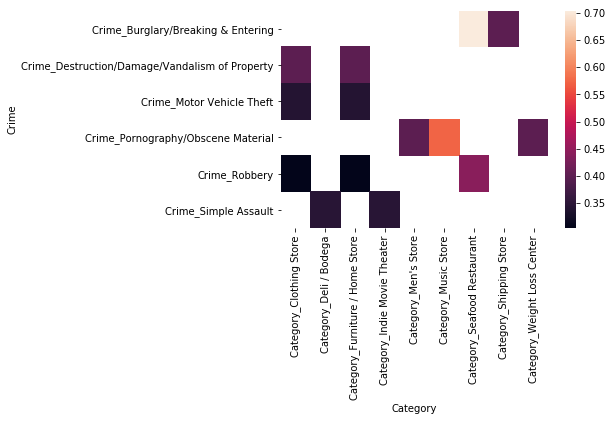

In [188]:
# Heatmap with a 100 meter radius from crime location
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(p_100)
plt.show()

In [192]:
crime_to_crime = [item for item in corr_200.index.values if item[1].startswith('Crime_')]
corr_200.drop(index=crime_to_crime, inplace=True)
corr_200.index.names = ['Crime','Category']
corr_200.reset_index(level=1, inplace=True)

In [193]:
p_200 = corr_200.pivot_table(index='Crime', columns='Category', values='correlation coef')

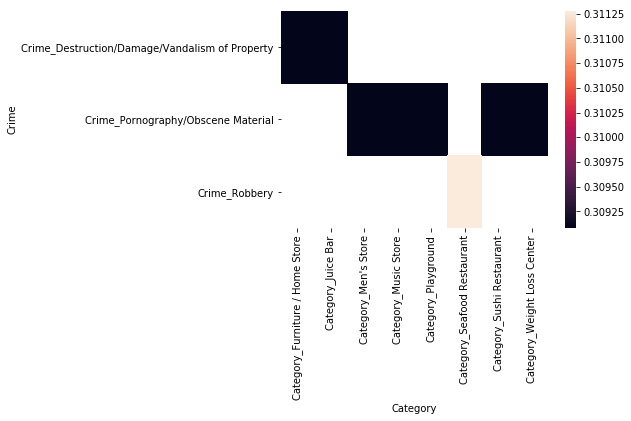

In [194]:
# Heatmap with a 100 meter radius from crime location
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(p_200)
plt.show()

## Discussion
Disappointingly, with a couple of exceptions, only moderate to weak correlations were found between any crime location and the category of popular venues in the vicinity. The strong correlations that were found would appear to be only coincidental. That is to say, I can't think of any reason to expect seafood restaurants to be highly correlated with Burglary/Breaking & Entering.

## Conclusion
In conclusion, I did not find sufficient evidence of any significant correlation between the places where crime occurs and the types of venues in the vicinity.  
I did find that certain crimes are highly correlated with one another, such as Robbery with Destruction/Damage/Vandalism of Property and Motor Vehicle Theft with Destruction/Damage/Vandalism of Property. A likely explanation for this is that a single event often involves both crimes.  
It is also worth note that places like parking lots and garages are not venues, per se, so are not returned by Foursquare's venues API. Visually inspecting the map makes it clear that Theft From Motor Vehicle occurs frequently in large parking areas, such as the Park and Ride garage and the Tacoma Mall. Perhaps more interesting results could be achived by repeating the study with a different set of location data.